# Day 38 · 模型可视化、训练进度与推理实践



**学习内容**
> - 模型结构可视化：快速理解参数规模与层次设计
> - tqdm 进度条：用流畅的交互感知训练过程
> - 推理模式：把训练好的模型进行应用



使用设备: cuda:0
Epoch [100/20000], Loss: 1.1066
Epoch [200/20000], Loss: 1.0971
Epoch [300/20000], Loss: 1.0891
Epoch [400/20000], Loss: 1.0792
Epoch [500/20000], Loss: 1.0646
Epoch [600/20000], Loss: 1.0428
Epoch [700/20000], Loss: 1.0181
Epoch [800/20000], Loss: 0.9879
Epoch [900/20000], Loss: 0.9521
Epoch [1000/20000], Loss: 0.9122
Epoch [1100/20000], Loss: 0.8702
Epoch [1200/20000], Loss: 0.8282
Epoch [1300/20000], Loss: 0.7883
Epoch [1400/20000], Loss: 0.7517
Epoch [1500/20000], Loss: 0.7188
Epoch [1600/20000], Loss: 0.6896
Epoch [1700/20000], Loss: 0.6640
Epoch [1800/20000], Loss: 0.6414
Epoch [1900/20000], Loss: 0.6215
Epoch [2000/20000], Loss: 0.6038
Epoch [2100/20000], Loss: 0.5878
Epoch [2200/20000], Loss: 0.5732
Epoch [2300/20000], Loss: 0.5597
Epoch [2400/20000], Loss: 0.5470
Epoch [2500/20000], Loss: 0.5349
Epoch [2600/20000], Loss: 0.5233
Epoch [2700/20000], Loss: 0.5120
Epoch [2800/20000], Loss: 0.5013
Epoch [2900/20000], Loss: 0.4908
Epoch [3000/20000], Loss: 0.4804
Epoch 

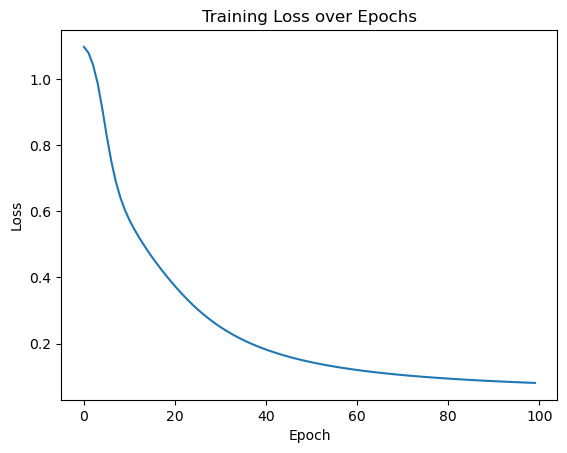

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt

# 设置GPU设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 加载鸢尾花数据集
iris = load_iris()
X = iris.data  # 特征数据
y = iris.target  # 标签数据

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 归一化数据
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 将数据转换为PyTorch张量并移至GPU
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.LongTensor(y_test).to(device)

model=nn.Sequential(
    nn.Linear(4, 10),
    nn.ReLU(),
    nn.Linear(10, 3)
).to(device)

# 分类问题使用交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 使用随机梯度下降优化器
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 训练模型
num_epochs = 20_000  # 训练的轮数

# 用于存储每100个epoch的损失值和对应的epoch数
losses = []

start_time = time.time()  # 记录开始时间

for epoch in range(num_epochs):
    # 前向传播
    outputs = model(X_train)  # 隐式调用forward函数
    loss = criterion(outputs, y_train)

    # 反向传播和优化
    optimizer.zero_grad() #梯度清零，因为PyTorch会累积梯度，所以每次迭代需要清零，梯度累计是那种小的batchsize模拟大的batchsize
    loss.backward() #  反向传播计算梯度
    optimizer.step() # 更新参数

    # 记录损失值
    if (epoch + 1) % 200 == 0:
        losses.append(loss.item()) # item()方法返回一个Python数值，loss是一个标量张量
    
    # 打印训练信息
    if (epoch + 1) % 100 == 0: # range是从0开始，所以epoch+1是从当前epoch开始，每100个epoch打印一次
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

time_all = time.time() - start_time  # 计算训练时间
print(f'Training time: {time_all:.2f} seconds')


# 可视化损失曲线
plt.plot(range(len(losses)), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

## 一、模型结构可视化

理解一个深度学习网络通常从两个问题入手：

1. 损失函数如何把任务目标量化？
2. 每一层的参数规模是否匹配任务难度？

把这两个问题想明白，才能用正确的方式去阅读模型结构输出。

### 1.1 nn.model自带的方法

In [2]:
print(model)

Sequential(
  (0): Linear(in_features=4, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=3, bias=True)
)


这是最基础、最简单的方法，直接打印模型对象，它会输出模型的结构，显示模型中各个层的名称和参数信息

In [3]:
for name,param in model.named_parameters():
    print(f"Parameter name: {name},Shape: {param.shape} ")

Parameter name: 0.weight,Shape: torch.Size([10, 4]) 
Parameter name: 0.bias,Shape: torch.Size([10]) 
Parameter name: 2.weight,Shape: torch.Size([3, 10]) 
Parameter name: 2.bias,Shape: torch.Size([3]) 


可以将模型中带有weight的参数（即权重）提取出来，并转为 numpy 数组形式，对其计算统计分布，并且绘制可视化图表

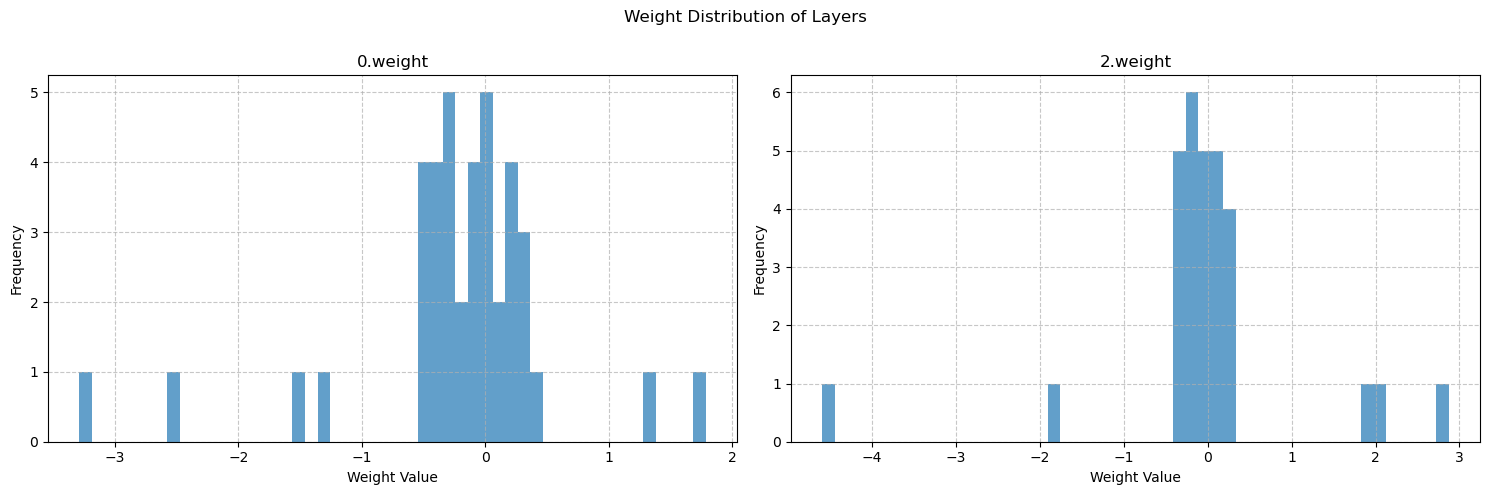


=== 权重统计信息 ===
0.weight:
  均值: -0.224772
  标准差: 0.826098
  最小值: -3.286768
  最大值: 1.786773
------------------------------
2.weight:
  均值: -0.022058
  标准差: 1.180873
  最小值: -4.591810
  最大值: 2.871279
------------------------------


In [ ]:
import numpy as np
weight_data={}
for name,param in model.named_parameters():
    if 'weight' in name:
        weight_data[name]=param.detach().cpu().numpy()

fig,axes =plt.subplots(1,len(weight_data),figsize=(15,5))
fig.suptitle('Weight Distribution of Layers')
for i,(name,weights) in enumerate(weight_data.items()):
    # 展平权重张量为一维数组
    weights_flat = weights.flatten()
    
    # 绘制直方图
    axes[i].hist(weights_flat, bins=50, alpha=0.7)
    axes[i].set_title(name)
    axes[i].set_xlabel('Weight Value')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

# 计算并打印每层权重的统计信息
print("\n=== 权重统计信息 ===")
for name, weights in weight_data.items():
    mean = np.mean(weights)
    std = np.std(weights)
    min_val = np.min(weights)
    max_val = np.max(weights)
    print(f"{name}:")
    print(f"  均值: {mean:.6f}")
    print(f"  标准差: {std:.6f}")
    print(f"  最小值: {min_val:.6f}")
    print(f"  最大值: {max_val:.6f}")
    print("-" * 30)

在对比如 `0.weight` 与 `2.weight` 的统计信息时，你会发现不同层的分布差异非常明显，这正反映了它们在任务中的角色不同。根据这些统计量可以做出更有根据的调参动作：

- 如果权重标准差过大导致训练不稳定，尝试降低学习率或使用梯度裁剪；
- 如果最小值、最大值始终飘忽不定，可以考虑增大正则化力度；
- 观察偏置项是否过大，能帮助判断是否需要重新设计层宽或初始化策略。

这样一来，模型结构输出与参数分布分析就形成了闭环。


### 1.2 torchsummary：轻量级的层级摘要

`torchsummary` 的 `summary(model, input_size=(4,))` 会模拟一次前向传播，把每一层的输出形状、参数量、可训练标记都整理成表格。和直接 `print(model)` 相比，它额外要求传入示例 `input_size`，以便推断张量的真实维度。


In [5]:
from torchsummary import summary
# 打印模型摘要，可以放置在模型定义后面
summary(model, input_size=(4,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              50
              ReLU-2                   [-1, 10]               0
            Linear-3                    [-1, 3]              33
Total params: 83
Trainable params: 83
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


不同场景下的 `input_size` 示例：

| 模型类型       | 输入类型               | `input_size` 示例         | 实际输入形状（batch_size=32） |
|----------------|------------------------|--------------------------|-----------------------------|
| MLP（单样本）  | 一维特征向量           | `(4,)`                   | `(32, 4)`                   |
| CNN（图像）    | 三维图像（C,H,W）      | `(3, 224, 224)`          | `(32, 3, 224, 224)`         |
| RNN（序列）    | 二维序列（seq_len, feat） | `(10, 5)`               | `(32, 10, 5)`               |

记住 `input_size` 描述的是单个样本的形状，`summary` 会自动在维度最前面补上 batch size。


### 1.3 torchinfo库的summary方法


`torchinfo` 和 `torchsummary` 的使用方式几乎一致，但它会进一步统计每一层的输入/输出形状、参数量、内存开销甚至 FLOPs，适合在模型迭代期评估不同结构的成本。搭配 TensorBoard 可以交叉验证各层尺寸是否匹配，下次会在可视化专题里继续展开。


In [ ]:
from torchinfo import summary
summary(model, input_size=(4, ))


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [3]                       --
├─Linear: 1-1                            [10]                      50
├─ReLU: 1-2                              [10]                      --
├─Linear: 1-3                            [3]                       33
Total params: 83
Trainable params: 83
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

## 二、tqdm 进度条

深度学习训练本质上是长循环，肉眼盯日志既耗费精力也难以及时发现异常。`tqdm` 提供了一个极简的上下文管理器，只要包裹住迭代器，就能实时看到剩余时间、迭代速度以及自定义描述。


### 2.1 手动更新的精细控制

当循环内部的步长不固定时，我习惯手动创建 `tqdm(total=...)`，并在每次完成一个阶段后调用 `pbar.update(n)`。这种写法配合 `with tqdm(...) as pbar` 能保证进度条在异常情况下也能正确收尾，特别适合嵌套循环或多阶段任务。


In [7]:
from tqdm import tqdm
import time

# 创建一个总步数为10的进度条
with tqdm(total=10) as pbar: # pbar是进度条对象的变量名
    # pbar 是 progress bar（进度条）的缩写，约定俗成的命名习惯。
    for i in range(10): # 循环10次（对应进度条的10步）
        time.sleep(0.1) # 模拟每次循环耗时0.5秒
        pbar.update(1) # 每次循环后，进度条前进1步

100%|██████████| 10/10 [00:01<00:00,  9.89it/s]


In [8]:
from tqdm import tqdm
import time

# 创建进度条时添加描述（desc）和单位（unit）
with tqdm(total=5,desc="下载文件",unit="个") as pbar:
    # 进度条这个对象，可以设置描述和单位
    # desc是描述，在左侧显示
    # unit是单位，在进度条右侧显示
    for i in range(5):
        time.sleep(1)
        pbar.update(1) # 每次循环进度+1

下载文件: 100%|██████████| 5/5 [00:05<00:00,  1.00s/个]


合理设置 `desc` 与 `unit` 参数，让输出更容易读懂：

- `unit="epoch"` 强调当前条目代表一个完整轮次；
- `unit="batch"` 或 `unit="sample"` 则适合面向小批量或逐条样本的任务。



### 2.2 自动更新

In [9]:
from tqdm import tqdm
import time

# 直接将range(3)传给tqdm，自动生成进度条
# 直接可以给这个对象内部传入一个可迭代对象，然后自动生成进度条
for i in tqdm(range(3), desc="处理任务", unit="epoch"):
    time.sleep(1)


处理任务: 100%|██████████| 3/3 [00:03<00:00,  1.00s/epoch]


`for i in tqdm(range(3), desc="处理任务", unit="个")`这个写法则不需要在循环中调用update()方法，更加简洁

实际上这2种写法都随意选取，这里都介绍下

In [10]:
# 用tqdm的set_postfix方法在进度条右侧显示实时数据（如当前循环的数值、计算结果等）：
from tqdm import tqdm
import time

total = 0  # 初始化总和
with tqdm(total=10, desc="累加进度") as pbar:
    for i in range(1, 11):
        time.sleep(0.3)
        total += i  # 累加1+2+3+...+10
        pbar.update(1)  # 进度+1
        pbar.set_postfix({"当前总和": total})  # 显示实时总和

累加进度: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s, 当前总和=55]


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # 导入tqdm库用于进度条显示

# 设置GPU设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 加载鸢尾花数据集
iris = load_iris()
X = iris.data  # 特征数据
y = iris.target  # 标签数据

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 归一化数据
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 将数据转换为PyTorch张量并移至GPU
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.LongTensor(y_test).to(device)

model=nn.Sequential(
    nn.Linear(4, 10),
    nn.ReLU(),
    nn.Linear(10, 3)
).to(device)

# 分类问题使用交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 使用随机梯度下降优化器
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 训练模型
num_epochs = 20000  # 训练的轮数

# 用于存储每100个epoch的损失值和对应的epoch数
losses = []
epochs = []

start_time = time.time()  # 记录开始时间

# 创建tqdm进度条
with tqdm(total=num_epochs, desc="训练进度", unit="epoch") as pbar:
    # 训练模型
    for epoch in range(num_epochs):
        # 前向传播
        outputs = model(X_train)  # 隐式调用forward函数
        loss = criterion(outputs, y_train)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 记录损失值并更新进度条
        if (epoch + 1) % 200 == 0:
            losses.append(loss.item())
            epochs.append(epoch + 1)
            # 更新进度条的描述信息
            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        # 每1000个epoch更新一次进度条
        if (epoch + 1) % 1000 == 0:
            pbar.update(1000)  # 更新进度条

    # 确保进度条达到100%
    if pbar.n < num_epochs:
        pbar.update(num_epochs - pbar.n)  # 计算剩余的进度并更新

time_all = time.time() - start_time  # 计算训练时间
print(f'Training time: {time_all:.2f} seconds')

# # 可视化损失曲线
# plt.figure(figsize=(10, 6))
# plt.plot(epochs, losses)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss over Epochs')
# plt.grid(True)
# plt.show()


使用设备: cuda:0


训练进度: 100%|██████████| 20000/20000 [00:13<00:00, 1476.69epoch/s, Loss=0.0620]

Training time: 13.55 seconds


## 三、模型推理：从训练走向应用

完成训练后，最后一公里就是“推理”（inference）阶段，也就是把数据送进训练好的网络，产出可交付的预测结果。下面这张表快速对比了经典机器学习与 PyTorch 深度学习在三个阶段的差异：

| 阶段 | 经典机器学习（Scikit-learn） | 深度学习（PyTorch） |
| --- | --- | --- |
| **模型构建 / 实例化** | `model = LinearRegression()`，优化逻辑已内置 | `model = NeuralNet()`，这里只定义网络结构 |
| **训练** | `model.fit(X_train, y_train)`，内部自动处理梯度 | `optimizer = torch.optim.Adam(...)`<br>`for epoch in epochs:`<br>`    optimizer.zero_grad()`<br>`    loss = loss_fn(model(X), y)`<br>`    loss.backward()`<br>`    optimizer.step()` |
| **推理** | `model.predict(X_test)` | `model.eval()`<br>`with torch.no_grad(): y_pred = model(X_test)` |

在深度学习里，训练阶段需要我们显式地管理优化器与梯度，但推理阶段只需关注 `model.eval()` 与前向传播。


In [2]:
# 在测试集上评估模型，此时model内部已经是训练好的参数了
# 评估模型
model.eval() # 设置模型为评估模式
with torch.no_grad(): # torch.no_grad()的作用是禁用梯度计算，可以提高模型推理速度
    outputs = model(X_test)  # 对测试数据进行前向传播，获得预测结果
    _, predicted = torch.max(outputs, 1) # torch.max(outputs, 1)返回每行的最大值和对应的索引
    #这个函数返回2个值，分别是最大值和对应索引，参数1是在第1维度（行）上找最大值，_ 是Python的约定，表示忽略这个返回值，所以这个写法是找到每一行最大值的下标
    # 此时outputs是一个tensor，p每一行是一个样本，每一行有3个值，分别是属于3个类别的概率，取最大值的下标就是预测的类别


    # predicted == y_test判断预测值和真实值是否相等，返回一个tensor，1表示相等，0表示不等，然后求和，再除以y_test.size(0)得到准确率
    # 因为这个时候数据是tensor，所以需要用item()方法将tensor转化为Python的标量
    # 之所以不用sklearn的accuracy_score函数，是因为这个函数是在CPU上运行的，需要将数据转移到CPU上，这样会慢一些
    # size(0)获取第0维的长度，即样本数量

    correct = (predicted == y_test).sum().item() # 计算预测正确的样本数
    accuracy = correct / y_test.size(0)
    print(f'测试集准确率: {accuracy * 100:.2f}%')

测试集准确率: 96.67%


`model.eval()` 会关闭 BatchNorm、Dropout 等训练期特有的策略，让推理输出保持稳定。但它不会自动禁用梯度，因为有时还需要利用梯度做可视化（例如 Grad-CAM）。所以我会显式包裹在 `with torch.no_grad():` 中，既省显存又确保不会意外更新参数。

完整的推理流程可以简化为：

1. 按需载入权重 `model.load_state_dict(...)`
2. 调用 `model.eval()` 切换到评估模式
3. 在 `with torch.no_grad():` 块里执行前向传播并收集输出

